In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cd /content/drive/MyDrive/PBS

/content/drive/MyDrive/PBS


In [ ]:
!pip install -r WBC_Detection/yolov7/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#BCCD (~90% Accuracy on BCCD dataset. Much lower on our dataset)

The BCCD model can count the number of RBCs, WBCs, and platelets, however, we will only be using the RBC count and the RBC bounding boxes. The WBC and Platelets will be calculated in the next steps.

In [ ]:
%cd Blood_Cell_Count/yolov7/

/content/drive/MyDrive/PBS/Blood_Cell_Count/yolov7


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.25 --iou 0.75 --source ../../input_images/test_image.jpg --save-txt --class 1 --project ../../RBC_count --name results
#class 0:Platelets, class1: RBC, class 2: WBC. Platelets and WBC calculated from other model better


Namespace(agnostic_nms=False, augment=False, classes=[1], conf_thres=0.01, device='', exist_ok=False, img_size=640, iou_thres=0.75, name='results', no_trace=False, nosave=False, project='/content/drive/MyDrive/PBS/RBC_count', save_conf=False, save_txt=True, source='/content/drive/MyDrive/PBS/test_image.jpg', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 

#WBC Detection (~95% Accuracy)

Using yolov7 model, We detect all the WBCs before cropping and classifying each WBC using the Leukopy project's vgg19 model.

In [ ]:
%cd ../../WBC_Detection/yolov7

/content/drive/MyDrive/PBS/WBC_Detection/yolov7


In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.01 --iou 0.75 --source ../../input_images/test_image.jpg --save-txt --project ../../WBC_count --name results


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=False, img_size=640, iou_thres=0.75, name='results', no_trace=False, nosave=False, project='/content/drive/MyDrive/PBS/WBC_count', save_conf=False, save_txt=True, source='/content/drive/MyDrive/PBS/test_image.jpg', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.13.1+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 


# Crop the WBCs

In [ ]:
import os
import shutil
import cv2

%cd ../../

if os.path.exists('detected_cropped_imgs'):
    shutil.rmtree('detected_cropped_imgs')

os.mkdir('detected_cropped_imgs')

labels_folder = "WBC_count/results/labels/"
#img_folder = "yolov7/runs/detect/exp6/"
img_file = "test_image.jpg"
for label_file in os.listdir(labels_folder):
        f = open(labels_folder+label_file, 'r')
        lines = f.readlines()
        count = 0 #for saving different cropped images from the same label_file. ie to create different file names for the cropped images.
                  #Plus, to count the number of WBC
        for line in lines:
          count = count+1
          #read the corresponding img file

          #use for when there is a folder of images
          #img = cv2.imread(img_folder + str(label_file[:-3]) + 'jpg')

          img = cv2.imread(img_file)
          
          # Get the x, y, width and height
          dh, dw, _ = img.shape
          class_id, x_center, y_center, w, h = line.strip().split()
          x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
          x_center = round(x_center * dw)
          y_center = round(y_center * dh)
          w = round(w * dw)
          h = round(h * dh)
          x = round(x_center - w / 2)
          y = round(y_center - h / 2)

          #crop the image and save it to "detected_cropped_imgs" folder
          crop_img = img[y:y + h, x:x + w]

          cv2.imwrite("detected_cropped_imgs/" + str(label_file[:-4]) +"_"+ str(count) + '.jpg', crop_img)
        

/content/drive/MyDrive/PBS


#WBC Classification (~95% Accuracy)



Using the vgg19 model from the Leukopy project from github, we classify each of the cropped WBCs found using the previous yolov7 model.

In [ ]:
%cd /Leukopy_Classification

/content/drive/MyDrive/PBS/Leukopy_Classification


In [ ]:
#from google.colab import files

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 360, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 360, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 180, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 180, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 180, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 90, 128)       0     

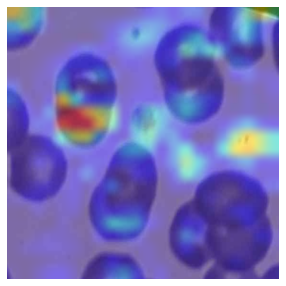

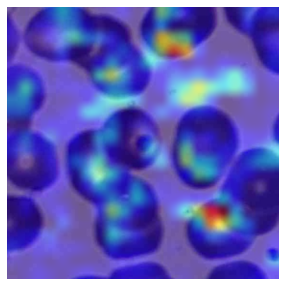

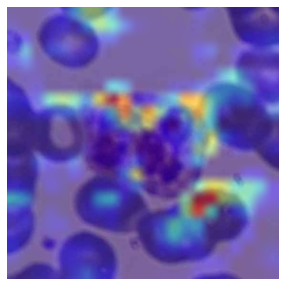

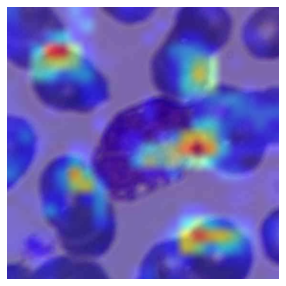

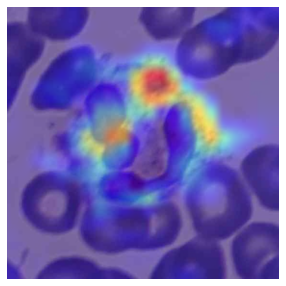

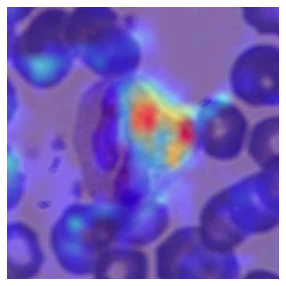

In [ ]:
from numpy.lib.shape_base import column_stack
#import streamlit as st
import matplotlib.pyplot as plt

from importlib import reload
from pathlib import Path
from PIL import Image
import os

import vgg19_utils as vgg19_utils

import common, ui

reload(vgg19_utils)

#img_file = "test_image.jpg"

model = vgg19_utils.load_model()
# Prédiction + Grad-CAM
cropped_imgs_path = "../detected_cropped_imgs/"
for img_file in os.listdir(cropped_imgs_path):
    fig, sorted_classes, sorted_preds = vgg19_utils.vgg19_prediction(
        model, cropped_imgs_path+img_file)

    # Prints the classes and their probability, ranked from highest to lowest.
    print(sorted_classes[0], vgg19_utils.print_proba(sorted_preds[0]))
    print(sorted_classes[1], vgg19_utils.print_proba(sorted_preds[1]))
    print(sorted_classes[2], vgg19_utils.print_proba(sorted_preds[2]))

    f = open("../detected_cropped_imgs/test_WBC_labels.txt", "a")
    f.write(img_file + " " + sorted_classes[0] + " " + vgg19_utils.print_proba(sorted_preds[0]) + "\n")
    f.close()


#print('Grad-CAM for', sorted_classes[0])
#fig = plt.figure() 
#plt.show()

#Final result

Count

In [ ]:
%cd ../

/content/drive/MyDrive/PBS


In [ ]:
f = open("RBC_count/results/labels/test_image.txt", "r")

RBC_count = 0
for line in f:
  RBC_count = RBC_count +1
#print(RBC_count)

f.close()

f = open("WBC_count/results/labels/test_image.txt", "r")

WBC_count = 0
for line in f:
  WBC_count = WBC_count +1
#print(WBC_count)

f.close()

f = open("detected_cropped_imgs/test_WBC_labels.txt", "r")


WBC_dict = {'BA': 'Basophils', 'BNE': 'Band Neutrophils', 'EO': 'Eosinophils', 'ERB': "Erythroblasts", 'LY': "Lymphocytes", 'MMY': "Metamyelocytes", 'MO': "Monocytes", 'MY': "Myelocytes", 'PLT': "Platelets", 'PMY': "Promyelocytes", 'SNE': "Neutrophils (segmented)"}

WBC_ind_count = {'Basophils': 0, 'Band Neutrophils': 0, 'Eosinophils': 0, 'Erythroblasts': 0, 'Lymphocytes': 0, 'Metamyelocytes': 0, 'Monocytes': 0, 'Myelocytes': 0, 'Platelets': 0, 'Promyelocytes': 0, 'Neutrophils (segmented)': 0}

for line in f:
  WBC_ind_count[WBC_dict[line.split()[1]]] = WBC_ind_count[WBC_dict[line.split()[1]]] + 1

WBC_count = WBC_count - WBC_ind_count['Platelets']

print("Final results:")
print("RBC count: ", RBC_count)
print("WBC count: ", WBC_count)
print("Platelets: ", WBC_ind_count['Platelets'])
print("WBC types: ")
print(WBC_ind_count)

Final results:
RBC count:  275
WBC count:  6
Platelets:  0
WBC types: 
{'Basophils': 0, 'Band Neutrophils': 0, 'Eosinophils': 2, 'Erythroblasts': 0, 'Lymphocytes': 2, 'Metamyelocytes': 0, 'Monocytes': 2, 'Myelocytes': 0, 'Platelets': 0, 'Promyelocytes': 0, 'Neutrophils (segmented)': 0}


Display

RBC boxes

In [ ]:
#img = cv2.imread("test_image.jpg")


#RBC Boxes

labels_folder = "RBC_count/results/labels/"
#img_folder = "yolov7/runs/detect/exp6/"
img_file = "test_image.jpg"
for label_file in os.listdir(labels_folder):
        f = open(labels_folder+label_file, 'r')
        lines = f.readlines()
        img = cv2.imread(img_file)

        for line in lines:
          
          # Get the x, y, width and height
          dh, dw, _ = img.shape
          class_id, x_center, y_center, w, h = line.strip().split()

          x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
          x_center = round(x_center * dw)
          y_center = round(y_center * dh)
          w = round(w * dw)
          h = round(h * dh)

          x1 = round(x_center - w / 2)
          y1 = round(y_center - h / 2)
          x2 = round(x_center + w / 2)
          y2 = round(y_center + h / 2)
          #print("x1, y1, x2, y2:", x1, y1, x2, y2)

          window_name = 'Image'
  
          # Start coordinate, here (5, 5)
          # represents the top left corner of rectangle
          start_point = (x1, y1)
            
          # Ending coordinate, here (220, 220)
          # represents the bottom right corner of rectangle
          end_point = (x2, y2)
            
            
          # Line thickness of 2 px
          thickness = 2
            
          # Using cv2.rectangle() method
          # Draw a rectangle with blue line borders of thickness of 2 px
          img = cv2.rectangle(img, start_point, end_point, (36, 255, 12), thickness = 2)
          cv2.putText(img, 'RBC', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

          cv2.imwrite("tst.jpg", img)





WBC and Platelets boxes

In [ ]:
# Blue color in BGR PLATELET
color = (255, 0, 0)
# Red color in BGR WBC
color = (0, 0, 255)



#WBC Boxes
img_file = "tst.jpg"

# The txt output of yolov7
f_wbc_count = open("WBC_count/results/labels/test_image.txt", 'r')
f_wbc_count_lines = f_wbc_count.readlines()

# The txt output of the leukopy classification
f_wbc_classes = open("detected_cropped_imgs/test_WBC_labels.txt", 'r')
f_wbc_classes_lines = f_wbc_classes.readlines()

for i in range(len(f_wbc_count_lines)):
  print()
  if f_wbc_classes_lines[i].split()[1] == "PLT":
    print("Platelet")

    # Get the x, y, width and height
    dh, dw, _ = img.shape
    class_id, x_center, y_center, w, h = f_wbc_count_lines[i].strip().split()

    x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
    x_center = round(x_center * dw)
    y_center = round(y_center * dh)
    w = round(w * dw)
    h = round(h * dh)

    x1 = round(x_center - w / 2)
    y1 = round(y_center - h / 2)
    x2 = round(x_center + w / 2)
    y2 = round(y_center + h / 2)
    #print("x1, y1, x2, y2:", x1, y1, x2, y2)

    window_name = 'Image'

    # Start coordinate, here (5, 5)
    # represents the top left corner of rectangle
    start_point = (x1, y1)
      
    # Ending coordinate, here (220, 220)
    # represents the bottom right corner of rectangle
    end_point = (x2, y2)
      
      
    # Line thickness of 2 px
    thickness = 2
      
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness = 2)
    cv2.putText(img, 'Platelet', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imwrite("tst.jpg", img)



  else:
    print("Not PLatelet")
    dh, dw, _ = img.shape
    class_id, x_center, y_center, w, h = f_wbc_count_lines[i].strip().split()

    x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
    x_center = round(x_center * dw)
    y_center = round(y_center * dh)
    w = round(w * dw)
    h = round(h * dh)

    x1 = round(x_center - w / 2)
    y1 = round(y_center - h / 2)
    x2 = round(x_center + w / 2)
    y2 = round(y_center + h / 2)
    #print("x1, y1, x2, y2:", x1, y1, x2, y2)

    window_name = 'Image'

    # Start coordinate, here (5, 5)
    # represents the top left corner of rectangle
    start_point = (x1, y1)
      
    # Ending coordinate, here (220, 220)
    # represents the bottom right corner of rectangle
    end_point = (x2, y2)
      
      
    # Line thickness of 2 px
    thickness = 2
      
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    img = cv2.rectangle(img, start_point, end_point, color = (0, 0, 255), thickness = 2)
    cv2.putText(img, 'WBC - '+WBC_dict[f_wbc_classes_lines[i].split()[1]], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color = (0, 0, 255), thickness = 2)

    cv2.imwrite("tst.jpg", img)




Not PLatelet

Not PLatelet

Not PLatelet

Not PLatelet

Not PLatelet

Not PLatelet
